# Excitation Generation via KernelSynth

For a time series zero-shot forecasting model, high-quality training data is essential.
To further supplement the training dataset, [Chronos](https://arxiv.org/abs/2403.07815) proposed
KernelSynth, a method to generate synthetic time series using Gaussian processes (GPs). The model struction of Chronos are show as fellow:

<p align="center">
  <img src="https://raw.githubusercontent.com/amazon-science/chronos-forecasting/main/figures/main-figure.png" width="100%">
  <br />
  <span>
    High-level depiction of Chronos. (<b>Left</b>) The input time series is scaled and quantized to obtain a sequence of tokens. (<b>Center</b>) The tokens are fed into a language model which may either be an encoder-decoder or a decoder-only model. The model is trained using the cross-entropy loss. (<b>Right</b>) During inference, we autoregressively sample tokens from the model and map them back to numerical values. Multiple trajectories are sampled to obtain a predictive distribution. The original code link is: https://github.com/amazon-science/chronos-forecasting.
  </span>
</p>


KernelSynth is inspired by the Automatic Statistician (Duvenaud et al., 2013), where a compositional search over a space of GP kernels is performed to explain the structure of a time series.
Chronos use the inverse of this process randomly compose GP kernels to generate new time series. The data generation process is shown below:

<p align="center">
  <img src="https://github.com/wwhenxuan/S2Generator/blob/master/images/algorithm_kernel_synth.jpg" width="100%">
</p>

The different kernel expressions and hyperparameter settings involved in the data generation process are shown in the following table:

| Kernel             | Formula                                                      | Hyperparameters                                              |
| ------------------ | ------------------------------------------------------------ | ------------------------------------------------------------ |
| Constant           | $\mathcal{K}_{\mathrm{Const}}(x, x') = C$                    | $C=1$                                                        |
| White Noise        | $\mathcal{K}_{\mathrm{White}}(x, x') = \sigma_n \cdot \mathrm{1}_{(x=x')}$ | $\sigma_n \in \{ 0.1, 1 \}$                                  |
| Linear             | $\mathcal{K}_{\mathrm{Lin}}(x, x') = \sigma ^ 2 + x \cdot x'$ | $\sigma \in \{ 0, 1, 10 \}$                                  |
| RBF                | $\mathcal{K}_{\mathrm{RBF}}(x, x') = \mathrm{exp} \left ( - \frac{\left \| x - x' \right \| ^ 2}{2 l ^ 2} \right ) $ | $l \in {0.1, 1, 10}$                                         |
| Rational Quadratic | $\mathcal{K}_{\mathrm{RQ}}(x, x') = \left ( 1 + \frac{\left \| x - x' \right \| ^ 2}{2 \alpha} \right )$ | $\alpha \in \{ 0.1, 1, 10 \}$                                |
| Reriodic           | $\mathcal{K}_{\mathrm{Per}}(x, x') = \mathrm{exp} \left ( - 2 \sin ^ 2 \left ( \pi \frac{\left \| x - x' \right \|}{p} \right ) \right )$ | $p \in \left \{ 24, 48, 96, 168, 336, 672, 7, 14, 30, 60, 365, 730, 4, 26, 52, 6, 12, 40, 10 \right \}$ |

In S2Generator, we further integrated and encapsulated this data generation algorithm, primarily transforming it from a process-oriented generation approach to an object-oriented one, which facilitates parameter control.

When we create a data generation object instance, we can adjust the parameters, mainly adjusting the minimum and maximum number of specific kernels to use, and whether to use the kernel method mentioned in the above table.

In [4]:
import numpy as np
from matplotlib import pyplot as plt
from S2Generator.excitation import KernelSynth

# Create the instance for ForecastPFN
kernel_synth = KernelSynth(
    min_kernels=1,
    max_kernels=5,  # How many cores to use for data generation
)

# Create the random number generator
rng = np.random.RandomState(0)

# Generate the excitation through `generate` method
time_series = kernel_synth.generate(
    rng=np.random.RandomState(0), input_dimension=1, n_inputs_points=512
)

print(
    f"The Excitation Method: {str(kernel_synth)} and Generate the Time Series Data with Shape: {time_series.shape}"
)

The Excitation Method: KernelSynth and Generate the Time Series Data with Shape: (512, 1)


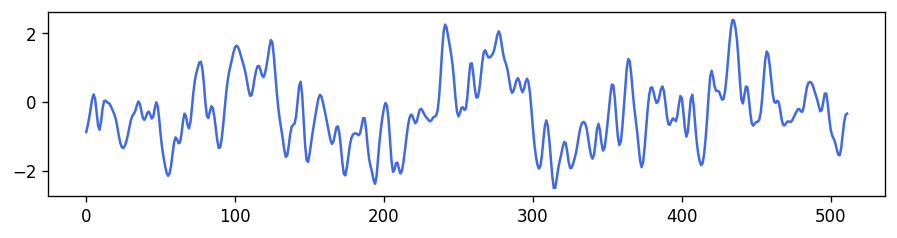

In [5]:
# Visualization for the excitation
fig, ax = plt.subplots(figsize=(9, 2), dpi=120)

ax.plot(time_series, color="royalblue")

We can use the class attributes to see how many kernel methods are available.

In [6]:
print("The Kernel Bank:")
print(kernel_synth.kernel_bank)

The Kernel Bank:
[ExpSineSquared(length_scale=1, periodicity=0.0469), ExpSineSquared(length_scale=1, periodicity=0.0938), ExpSineSquared(length_scale=1, periodicity=0.188), ExpSineSquared(length_scale=1, periodicity=0.328), ExpSineSquared(length_scale=1, periodicity=0.656), ExpSineSquared(length_scale=1, periodicity=1.31), ExpSineSquared(length_scale=1, periodicity=0.0137), ExpSineSquared(length_scale=1, periodicity=0.0273), ExpSineSquared(length_scale=1, periodicity=0.0586), ExpSineSquared(length_scale=1, periodicity=0.117), ExpSineSquared(length_scale=1, periodicity=0.713), ExpSineSquared(length_scale=1, periodicity=1.43), ExpSineSquared(length_scale=1, periodicity=0.00781), ExpSineSquared(length_scale=1, periodicity=0.0508), ExpSineSquared(length_scale=1, periodicity=0.102), ExpSineSquared(length_scale=1, periodicity=0.00781), ExpSineSquared(length_scale=1, periodicity=0.0117), ExpSineSquared(length_scale=1, periodicity=0.0234), ExpSineSquared(length_scale=1, periodicity=0.00781), E

We can adjust and set the specific type of algorithm core to use by passing in a bool value when creating the algorithm object.

In [13]:
# Create generators with different parameters by controlling variables
excitation_list = []

# List of various algorithm kernels
kernel_list = [
    "exp_sine_squared",
    "dot_product",
    "rbf",
    "rational_quadratic",
    "white_kernel",
    "constant_kernel",
]
params_list = [3, 3, False, False, False, False, False, False]

for i in range(6):
    i_list = params_list.copy()
    i_list[i + 2] = True

    # Create a specific algorithm object
    kernel_synth = KernelSynth(*i_list)
    kernel_synth.set_length(length=512)

    print(kernel_list[i], "bank list:")
    print(kernel_synth.kernel_bank, "\n")

    # Add the data generation object to the list
    excitation_list.append(kernel_synth)

exp_sine_squared bank list:
[ExpSineSquared(length_scale=1, periodicity=0.0469), ExpSineSquared(length_scale=1, periodicity=0.0938), ExpSineSquared(length_scale=1, periodicity=0.188), ExpSineSquared(length_scale=1, periodicity=0.328), ExpSineSquared(length_scale=1, periodicity=0.656), ExpSineSquared(length_scale=1, periodicity=1.31), ExpSineSquared(length_scale=1, periodicity=0.0137), ExpSineSquared(length_scale=1, periodicity=0.0273), ExpSineSquared(length_scale=1, periodicity=0.0586), ExpSineSquared(length_scale=1, periodicity=0.117), ExpSineSquared(length_scale=1, periodicity=0.713), ExpSineSquared(length_scale=1, periodicity=1.43), ExpSineSquared(length_scale=1, periodicity=0.00781), ExpSineSquared(length_scale=1, periodicity=0.0508), ExpSineSquared(length_scale=1, periodicity=0.102), ExpSineSquared(length_scale=1, periodicity=0.00781), ExpSineSquared(length_scale=1, periodicity=0.0117), ExpSineSquared(length_scale=1, periodicity=0.0234), ExpSineSquared(length_scale=1, periodicity=

We further use single-type kernel objects for data generation and visualization analysis.

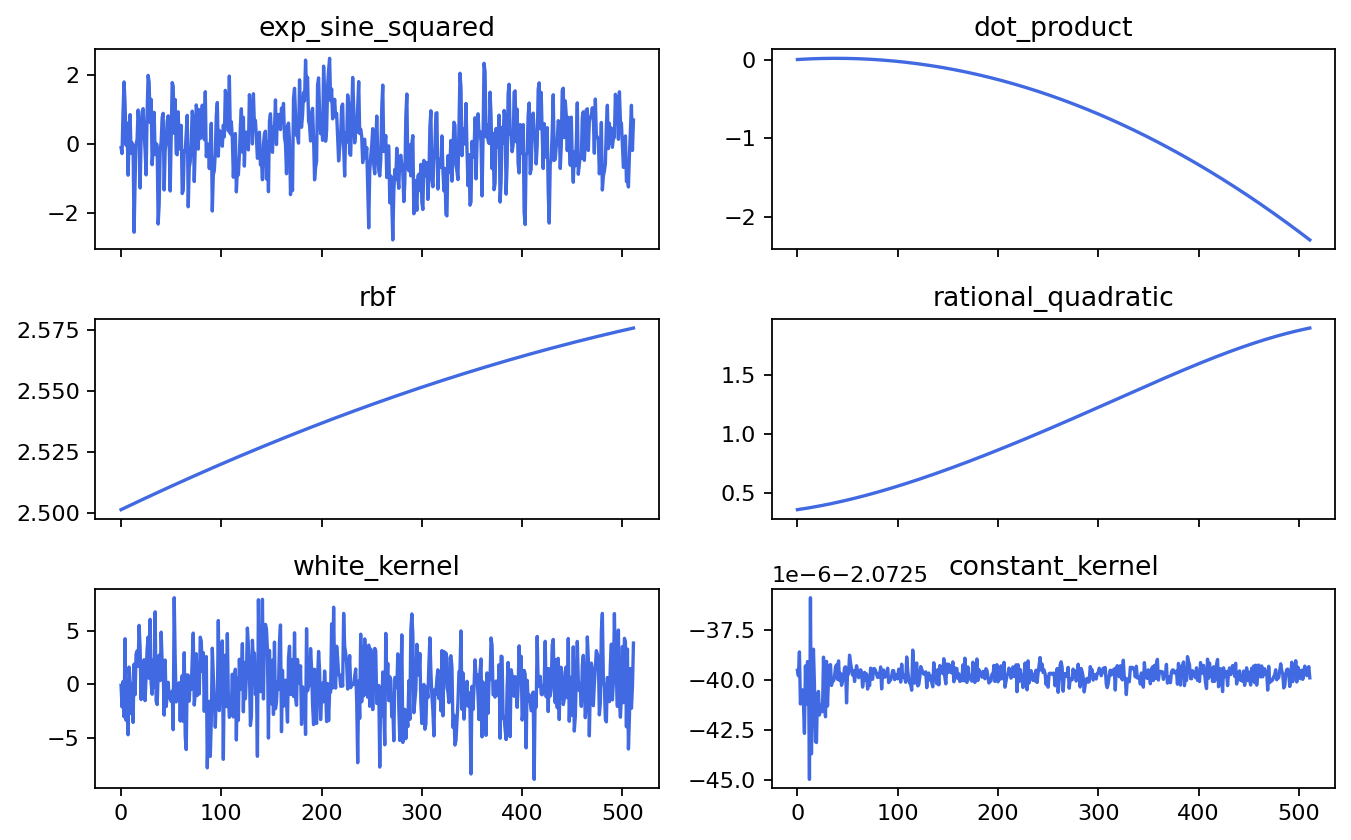

In [21]:
# Create the plotting figures
fig, ax = plt.subplots(3, 2, figsize=(10, 6), dpi=160, sharex=True)
fig.subplots_adjust(hspace=0.35)

for i in range(3):
    for j in range(2):
        # Data generation using an object with a single kernel parameter
        kernel_synth = excitation_list[i * 2 + j]
        time_series = kernel_synth.generate(
            rng=rng, input_dimension=1, n_inputs_points=512
        )

        # plot the time series data
        ax[i, j].plot(time_series, color="royalblue")

        # set the title for the kernel
        ax[i, j].set_title(kernel_list[i * 2 + j])